In [1]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt


face2 = cv2.imread("img1.jpg")
face1 = cv2.imread("img4.png")

face1_bw = cv2.cvtColor(face1, cv2.COLOR_BGR2GRAY)
face2_bw = cv2.cvtColor(face2, cv2.COLOR_BGR2GRAY)


height, width, _ = face1.shape
mask = np.zeros((height, width), np.uint8)

height, width, _ = face2.shape

In [2]:
def get_landmarks(landmarks):
  landmarks_points = []
  
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))
  return landmarks_points

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")


rect = detector(face1_bw)[0]

landmarks = predictor(face1_bw, rect)
landmarks_points = np.array(get_landmarks(landmarks), np.int32)

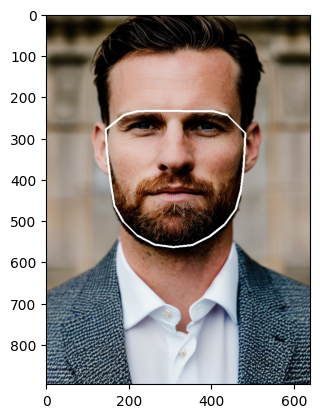

In [3]:
convexhull = cv2.convexHull(landmarks_points) 

face1_cp = face1.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face1_cp, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

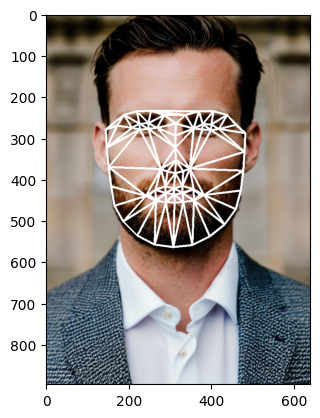

In [4]:
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points.tolist())
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

triangles_indexes = []
face1_cp = face1.copy()


for triangle in triangles :
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    cv2.line(face1_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(face1_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(face1_cp, pt3, pt1, (255, 255, 255), 3,  0)

    index_pt1 = np.where((landmarks_points == pt1).all(axis=1))[0][0]
    index_pt2 = np.where((landmarks_points == pt2).all(axis=1))[0][0]
    index_pt3 = np.where((landmarks_points == pt3).all(axis=1))[0][0]

    vertices = [index_pt1, index_pt2, index_pt3]
    triangles_indexes.append(vertices)

plt.imshow(cv2.cvtColor(face1_cp, cv2.COLOR_BGR2RGB))

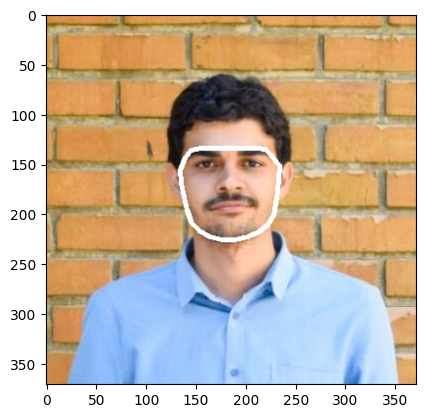

In [5]:
rect2 = detector(face2_bw)[0]

landmarks_2 = predictor(face2_bw, rect2)

landmarks_points2 = np.array(get_landmarks(landmarks_2), np.int32)
convexhull2 = cv2.convexHull(landmarks_points2)

face2_cp = face2.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face2_cp, [convexhull2], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

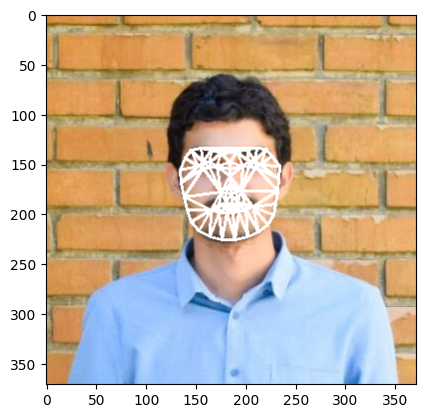

In [6]:
subdiv = cv2.Subdiv2D(cv2.boundingRect(convexhull2))
subdiv.insert(landmarks_points2.tolist())
triangles2 = subdiv.getTriangleList()
triangles2 = np.array(triangles2, dtype=np.int32)


face2_cp = face2.copy()

for triangle in triangles2:
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    cv2.line(face2_cp, pt1, pt2, (255, 255, 255), 2,  0)
    cv2.line(face2_cp, pt2, pt3, (255, 255, 255), 2,  0)
    cv2.line(face2_cp, pt3, pt1, (255, 255, 255), 2,  0)

plt.imshow(cv2.cvtColor(face2_cp, cv2.COLOR_BGR2RGB))

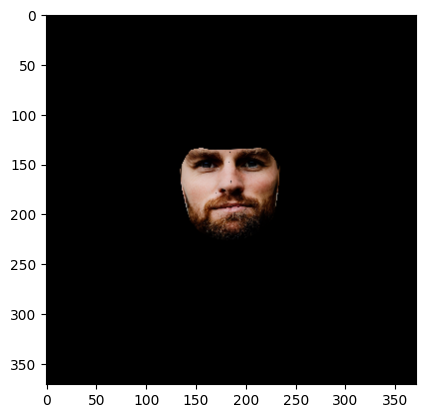

In [7]:
new_face = np.zeros((height, width, 3), np.uint8)


for triangle in triangles_indexes:
    pt1 = landmarks_points[triangle[0]]
    pt2 = landmarks_points[triangle[1]]
    pt3 = landmarks_points[triangle[2]]

    (x, y, width, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = face1[y: y+height, x: x+width]
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)

    pt1 = landmarks_points2[triangle[0]]
    pt2 = landmarks_points2[triangle[1]]
    pt3 = landmarks_points2[triangle[2]]

    (x, y, width, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,width), np.uint8)
    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (width, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)
    
    new_face_rect_area = new_face[y: y+height, x: x+width]
    new_face_rect_area_gray = cv2.cvtColor(new_face_rect_area, cv2.COLOR_BGR2GRAY)

    _, masked_triangle = cv2.threshold(new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle)
    new_face_rect_area = cv2.add(new_face_rect_area, dist_triangle)
    new_face[y: y+height, x: x+width] = new_face_rect_area
  
plt.imshow(cv2.cvtColor(new_face, cv2.COLOR_BGR2RGB))
plt.show()

Finally, we can swap the face masks:

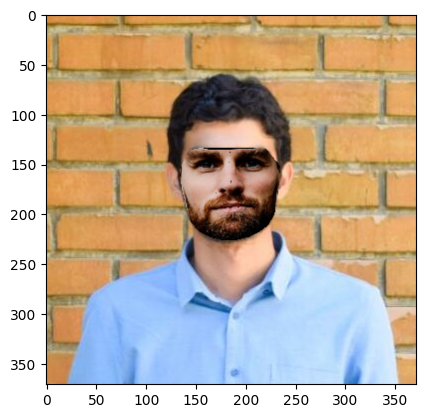

In [8]:
face_mask = cv2.bitwise_not(cv2.fillConvexPoly(np.zeros_like(face2_bw), convexhull2, 255))

body_maskless = cv2.bitwise_and(face2, face2, mask=face_mask)
result = cv2.add(body_maskless, new_face)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

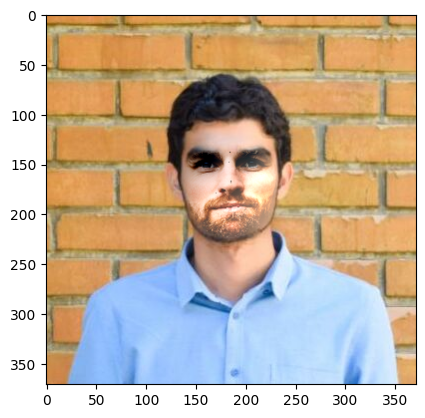

In [9]:
(x, y, width, height) = cv2.boundingRect(convexhull2)
center_face2 = (int((x+x+width)/2), int((y+y+height)/2))

seamlessclone = cv2.seamlessClone(result, face2, cv2.bitwise_not(face_mask), center_face2, cv2.NORMAL_CLONE)

plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))